# Clustering

## Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans

%matplotlib inline

## Generate data

In [2]:
# number of clusters
K = 3

# number of samples
N = 100

# feature space: x (height)
x_scale_max = 200
x_scale_min = 0

# feature space: y (weight)
y_scale_max = 100
y_scale_min = 0

# Randomly generated data
x = np.random.randint(x_scale_min, x_scale_max, N)
y = np.random.randint(y_scale_min, y_scale_max, N)

# Randomly generated cluster centroids 
kx = np.random.randint(x_scale_min, x_scale_max, K)
ky = np.random.randint(y_scale_min, y_scale_max, K)

## Plot the data

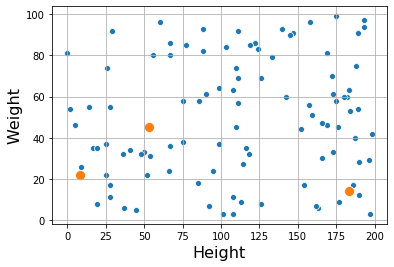

In [3]:
data = np.stack((x, y), axis=-1)
dataset_df = pd.DataFrame(data, columns=['height', 'weight'])
clusters_df = pd.DataFrame({'kx': kx, 'ky': ky})

#plt.figure(figsize=(8, 8))
sns.scatterplot(x='height', y='weight', data=dataset_df)
sns.scatterplot(x='kx', y='ky', s=100, data=clusters_df)
plt.xlabel("Height",fontsize=16)
plt.ylabel("Weight",fontsize=16)
plt.grid()
plt.show()

## K-means

- [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

    - cluster_centers_ (array, [n_clusters, n_features]): Coordinates of cluster centers. If the algorithm stops before fully converging (see tol and max_iter), these will not be consistent with labels_.
    - labels_: Labels of each point
    - inertia_ (float): Sum of squared distances of samples to their closest cluster center.
    - n_iter_ (int): Number of iterations run.

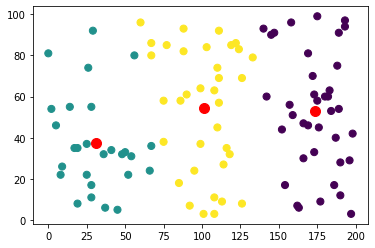

In [4]:
# K-means
kmeans = KMeans(n_clusters=K, random_state=0, n_init=100).fit(dataset_df)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# plot
plt.scatter(x, y, c=cluster_labels, s=50)
#sns.scatterplot(x='height', y='weight', hue=cluster_labels, s=50, data=dataset_df)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100)

## Optimal number of clusters

- Elbow method (also known as Hartigan method）
- Average Silhouette method (側影圖法)
- Gap statistic method (Gap統計量，預測-觀測)

### Elbow Metho

-  WCSS (total within-cluster sum of square)

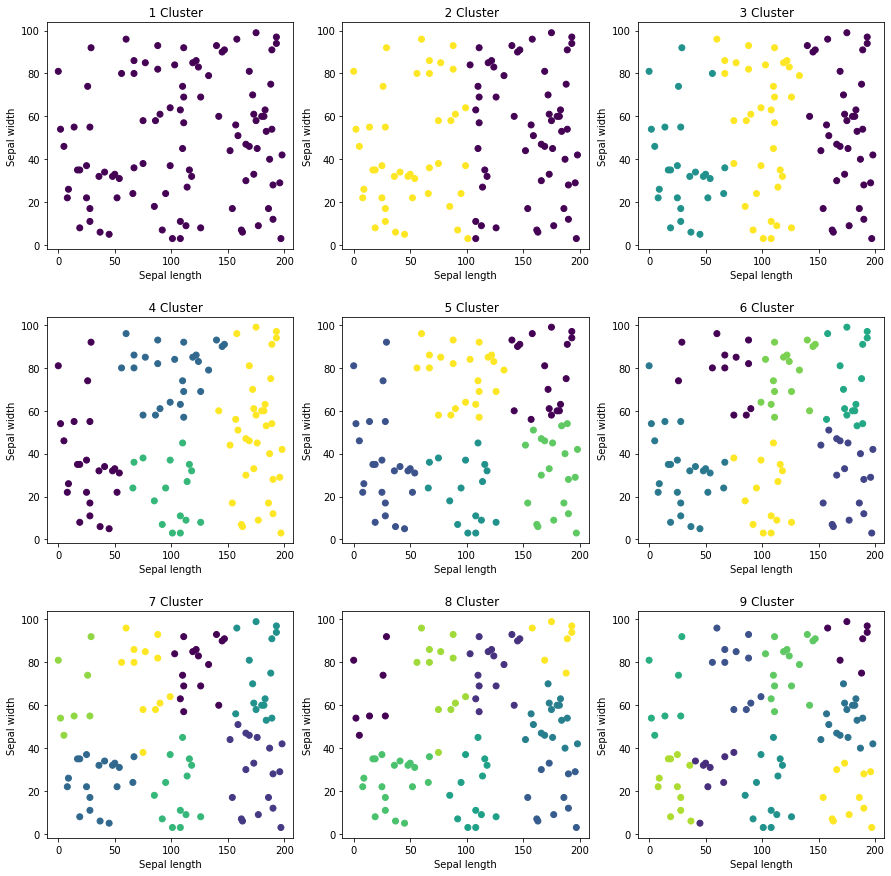

In [5]:
# Choose K and plot the k cluster 
plt.figure(figsize=(15, 15))
wcss = []
ks = range(1, 10)
for k in ks:
    kmeans = KMeans(n_clusters=k,  random_state=0).fit(dataset_df)
    cluster_labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    
    plt.subplot(3, 3, k)
    plt.subplots_adjust(hspace=0.3)
    plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)
    #sns.scatterplot(x='height', y='weight', hue=cluster_labels, data=dataset_df)
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.title("%4d Cluster" % k)
plt.show()

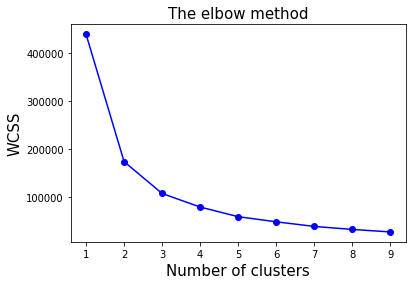

In [6]:
# Graph of WCSS
plt.plot(range(1, 10), wcss, 'bo-')
plt.title('The elbow method', fontsize = 15)
plt.xlabel('Number of clusters', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15) 
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

### Average Silhouette method

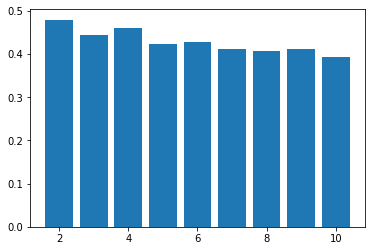

In [7]:
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k).fit(data)
    cluster_labels = kmeans.labels_
    silhouette_avg = metrics.silhouette_score(data, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

plt.bar(ks, silhouette_avgs)
plt.show()

## [Option] Implement K-means

In [8]:
# distance of two point
def L2_dis(x, y, kx, ky):
    return int(((kx-x)**2 + (ky-y)**2)**0.5)

# Group each data point
def cluster(x, k, kx, ky, n_clusters=3):
    group = []
    for i in range(n_clusters):
        group.append([])
        
    mid_dis = x_scale_max * y_scale_max
    for i in range(N):
        for j in range(n_clusters):
            distant = L2_dis(x[i], y[i], kx[j], ky[j])
            if distant < mid_dis:
                mid_dis = distant
                flag = j
        group[flag].append([x[i], y[i]])
        mid_dis = x_scale_max * y_scale_max
    return group

# 在全部資料點分群完畢後 > 計算平均 > 更新群心
def re_compute_centroids(group, kx, ky):
    sum_x = sum_y = 0
    new_centroids = []
    
    for index, nodes in enumerate(group):
        if nodes == []:
            new_centroids.append([kx[index], ky[index]])
        for node in nodes:
            sum_x += node[0]
            sum_y += node[1]
        new_centroids.append([int(sum_x/len(nodes)), int(sum_y/len(nodes))])
        sum_x = sum_y = 0

    nkx = []
    nky = []
    for i in new_centroids:
        nkx.append(i[0])
        nky.append(i[1])
    return nkx, nky

# K-means Clustering
def kmeans(x, y, kx, ky, n_clusters=3, fig=0):
    group = cluster(x, y, kx, ky, n_clusters)
    nkx, nky = re_compute_centroids(group, kx, ky)
    
    # 繪圖
    cx = []
    cy = []
    line = plt.gca()
    for index, nodes in enumerate(group):
        for node in nodes:
            cx.append([node[0], nkx[index]])
            cy.append([node[1], nky[index]])
        for i in range(len(cx)):
            line.plot(cx[i], cy[i], color='r', alpha=0.6)
        cx = []
        cy = []

    feature = plt.scatter(x, y)
    k_feature = plt.scatter(kx, ky)
    nk_feaure = plt.scatter(np.array(nkx), np.array(nky), s=50)
    #if save_img:
    #    plt.savefig(save_path + '%s.png' % fig)
    plt.show()

    # 判斷是否收斂
    if nkx == list(kx) and nky == (ky):
        return
    else:
        fig += 1
        kmeans(x, y, nkx, nky, n_clusters, fig)

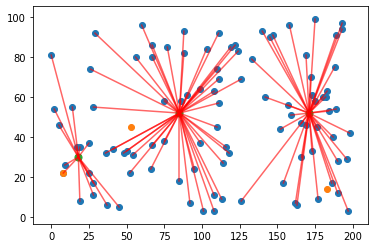

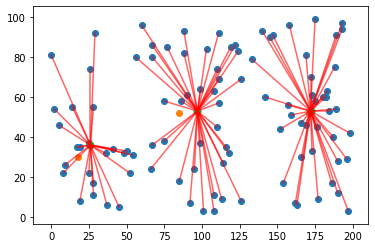

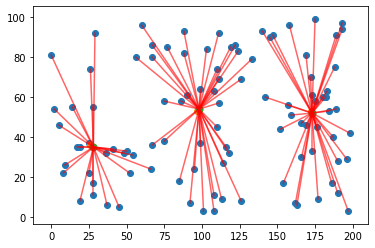

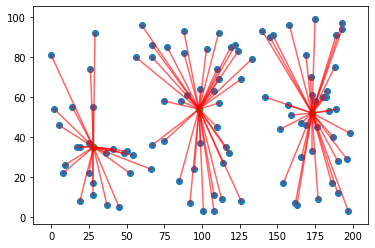

In [9]:
kmeans(x, y, kx, ky, K)